# OA Breast phantom

This example shows how to download and extract phantoms from the Optical and Acoustic Breast Phantom Database (OA-Breast) provided by the Computational Imaging Science Laboratory at Washington University St. Louis.


### Download data
Download the data of one or several phantoms from here:

https://wustl.app.box.com/s/rqivtin0xcofjwlkz43acou8jknsbfx8/folder/38729552500

### Tissue properties

The hdf5 files contain segmented phantom data. 
The labels correspond to the following tissues:

	0: background	
    2: fibro-glandular tissue		
    3: fat		
    4: skin layer		
    5: blood vessel	
    
For this example we will use the values for speed-of-sound `sos` and density `rho` as indicated below. Feel free to adjust these values.

In [1]:
sos = {}
sos['0'] = 1500.0
sos['2'] = 1510.0
sos['3'] = 1470.0
sos['4'] = 1650.0
sos['5'] = 1584.0

rho = {}
rho['0'] = 1000.0
rho['2'] = 1040.0
rho['3'] = 937.0
rho['4'] = 1150.0
rho['5'] = 1040.0

### Phantom interpolation

Next, we read the phantom data from the file and project it on a rectilinear mesh. 

Different waveform solvers have different ways to represent the properties of the tissue. 
For instance, this could be a set of piecewise constant parameters on a mesh of voxels, linearly varying structured meshes, point clouds, or fully unstructured meshes.

We will utilize a simple class for rectinlinear meshes, to allows us to easily extract 2D slices, to adjust the spatial grid, or to interpolate the phantom onto arbitrary unstructured meshes or point clouds.


In [2]:
import h5py
import numpy as np
import usct_tools as usct

In [3]:
spacing = 0.0002   # grid spacing in [m]

# choose one of Neg_07_Left.h5, Neg_35_Left.h5, or Neg_47_Left.h5
phantom_file = 'Neg_35_Left.h5'

with h5py.File(phantom_file, 'r') as f:
    npoints = f['phan'].shape
    
    # center phantom around (0,0,0)
    size = spacing * np.asarray(npoints)
    origin = - size / 2

    g = usct.grid(3, origin, spacing * np.ones(3), np.asarray(npoints))
    phantom = f['phan']
    
    soundspeed = np.zeros(npoints)
    density = np.zeros(npoints)
    
    for label in sos:
        mask = (phantom[:,:,:] == int(label))
        soundspeed[mask] = sos[label]
        density[mask] = rho[label]        
    
    g.attach_field('soundspeed', soundspeed)
    g.attach_field('density', density)
    g.write_hdf5_model('oa_phantom.h5', create_xdmf=True)


Adding new field soundspeed
Adding new field density


Now, we have created a grid object `g` that stores the phantom data. Additionally, we have written the phantom with the physical tissue parameters to an `hdf5` file. Visualizing 3D data in this notebook is tricky, but you can open the file in [Paraview](https://www.paraview.org/).

Paraview is a powerful visualization software for 2D and 3D data sets. To visualize the phantom, open the auxiliary `xdmf` file `oa_phantom.xdmf` with Paraview and select the `Xdmf Reader`. The `xdmf` file contains meta information that will tell Paraview how to access the data in the `hdf5` file.

## Extracting slices

Using the grid class, we can easily extract 2D slices of the phantom. We only need to select the axis of the constant plane (`0`,`1`, or `2`) and the index of the slice. This returns a new, two dimensional grid object and automatically extracts all tissue properties.

In [4]:
g_2d = g.extract_slice(2,200)
g_2d.write_hdf5_model('slice.h5', create_xdmf=True)

Adding new field soundspeed
Adding new field density


We can plot the 2D slice directly in the notebook.

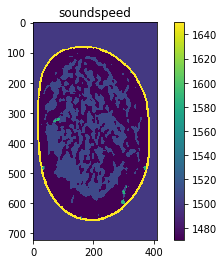

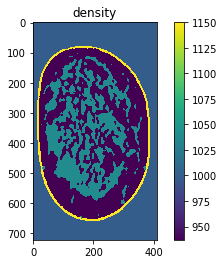

In [5]:
g_2d.plot()

## Changing the grid

In [6]:
# create a new grid with different grid spacing
g_2d_coarse = usct.grid(2, g_2d.origin, g_2d.spacing * 4.0, g_2d.npoints/ 4)

# retrieve a point cloud of the new grid and interpolate the data onto it
p = g_2d_coarse.points()
newdata = g_2d.interpolate(p, 4)

# attach all tissue parameters to the new grid
for f in newdata:
    g_2d_coarse.attach_field(f, newdata[f])

Adding new field soundspeed
Adding new field density


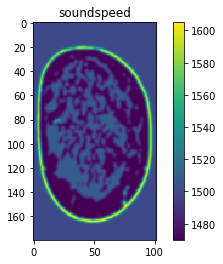

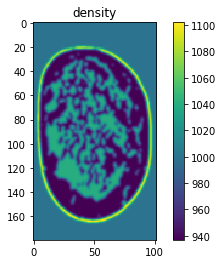

In [7]:
g_2d_coarse.plot()

### Reference

Yang Lou, Weimin Zhou, Thomas P. Matthews, Catherine M. Appleton, Mark A. Anastasio, “Generation of anatomically realistic numerical phantoms for photoacoustic and ultrasonic breast imaging,” J. Biomed. Opt. 22(4), 041015 (2017), doi: [10.1117/1.JBO.22.4.041015.](http://biomedicaloptics.spiedigitallibrary.org/article.aspx?articleid=2600985)

